# Analysis of Respiratory Data during Tonic-clonic Seizures

In [42]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import resample
import seaborn as sns

from preepiseizures.src import Patient, biosignal_processing
import Respiration_2023 as resp

In [6]:
# choose patient
patient = 'BLIW'

# get metadata
patient_info = Patient.patient_class(patient)
patient_info.get_seizure_annotations()
patient_info.seizure_table

Crises       Data Hora Clínica  Localização  lado Focal / Generalisada  \
0  Crise1 2022-10-24     13:21:11          NaN   NaN                 FUAS   
1  Crise2 2022-10-27     18:13:44          NaN   NaN                 FBTC   
2  Crise3 2022-10-27     20:30:32          NaN   NaN                 FBTC   
3  Crise4 2022-10-28     04:06:52          NaN   NaN                 FBTC   

   Fim  Sono/ Vigília  Tipo           Timestamp  
0  NaN            NaN   NaN 2022-10-24 13:21:11  
1  NaN            NaN   NaN 2022-10-27 18:13:44  
2  NaN            NaN   NaN 2022-10-27 20:30:32  
3  NaN            NaN   NaN 2022-10-28 04:06:52

In [12]:
# get data
data_path = f'data{os.sep}respiration{os.sep}{patient}_all_respiration_data.parquet'

data = pd.read_parquet(data_path)
data.head(5)

RESP         ECG                      datetime
0 -0.550698  327.377781 2022-10-24 17:20:30.102147000
1 -1.115533  548.140230 2022-10-24 17:20:30.114649453
2 -0.980881  380.440441 2022-10-24 17:20:30.127151907
3 -1.068967  432.321766 2022-10-24 17:20:30.139654360
4 -1.015300  324.646437 2022-10-24 17:20:30.152156814

In [18]:
data['datetime'] += pd.Timedelta(patient_info.patient_dict['temporal_shift'])
data.head(-5)

RESP         ECG                      datetime
0        -0.550698  327.377781 2022-10-24 18:00:10.102147000
1        -1.115533  548.140230 2022-10-24 18:00:10.114649453
2        -0.980881  380.440441 2022-10-24 18:00:10.127151907
3        -1.068967  432.321766 2022-10-24 18:00:10.139654360
4        -1.015300  324.646437 2022-10-24 18:00:10.152156814
...            ...         ...                           ...
26572718 -0.042358  306.336951 2022-10-28 15:10:19.265579933
26572719  0.071451  283.779657 2022-10-28 15:10:19.278079940
26572720 -0.062044  357.848461 2022-10-28 15:10:19.290579947
26572721  0.084142  415.840801 2022-10-28 15:10:19.303079955
26572722 -0.088694  480.689454 2022-10-28 15:10:19.315579962

[26572723 rows x 3 columns]

## Autoencoder for Respiration - Epilepsy

1) Filter Respiratory Signals
2) Segment into 1 minute segments (with overlap)
3) Normalize segments between 0 and 1

4) Give to the model trained in the RGBT data

In [19]:
corr_points = pd.read_parquet(f'data{os.sep}respiration{os.sep}{patient}_respiration_corr_points_all.parquet')
time_corr_points = [pd.date_range(corr_points.index[i], corr_points.index[i]+pd.Timedelta(seconds=60), periods=10) for i in range(len(corr_points.index))]
corr_points = pd.DataFrame(np.hstack(corr_points.values), index=np.hstack(time_corr_points))
corr_points

0
2022-10-24 17:51:30.104880842  0.145904
2022-10-24 17:51:36.771547508 -0.479060
2022-10-24 17:51:43.438214175  0.276380
2022-10-24 17:51:50.104880842 -0.714771
2022-10-24 17:51:56.771547508  0.266106
...                                 ...
2022-10-28 14:30:03.436372143  0.252490
2022-10-28 14:30:10.103038810  0.047631
2022-10-28 14:30:16.769705476  0.270539
2022-10-28 14:30:23.436372143  0.604602
2022-10-28 14:30:30.103038810  0.652211

[54230 rows x 1 columns]

In [20]:
data_part = data.loc[data['datetime'].between(corr_points.index[0], corr_points.index[-1])].copy()
data_part.head(5)

RESP         ECG                      datetime
0 -0.550698  327.377781 2022-10-24 18:00:10.102147000
1 -1.115533  548.140230 2022-10-24 18:00:10.114649453
2 -0.980881  380.440441 2022-10-24 18:00:10.127151907
3 -1.068967  432.321766 2022-10-24 18:00:10.139654360
4 -1.015300  324.646437 2022-10-24 18:00:10.152156814

In [155]:
corr_points

0                      datetime
2022-10-24 17:51:30.104880842  0.145904 2022-10-24 18:11:20.104880842
2022-10-24 17:51:36.771547508 -0.479060 2022-10-24 18:11:26.771547508
2022-10-24 17:51:43.438214175  0.276380 2022-10-24 18:11:33.438214175
2022-10-24 17:51:50.104880842 -0.714771 2022-10-24 18:11:40.104880842
2022-10-24 17:51:56.771547508  0.266106 2022-10-24 18:11:46.771547508
...                                 ...                           ...
2022-10-28 14:30:03.436372143  0.252490 2022-10-28 14:49:53.436372143
2022-10-28 14:30:10.103038810  0.047631 2022-10-28 14:50:00.103038810
2022-10-28 14:30:16.769705476  0.270539 2022-10-28 14:50:06.769705476
2022-10-28 14:30:23.436372143  0.604602 2022-10-28 14:50:13.436372143
2022-10-28 14:30:30.103038810  0.652211 2022-10-28 14:50:20.103038810

[54230 rows x 2 columns]

In [159]:
from scipy.signal import periodogram

f, Pxx = periodogram(corr_points[0], fs=1/6)

fig = go.Figure()
fig.add_trace(go.Scatter(x=f, y=Pxx, mode='lines'))
fig.show()


In [160]:
1/6

0.16666666666666666

## Analysis of Correlation During Seizures

In [27]:
corr_points['datetime'] = corr_points.index
corr_points['datetime'] += pd.Timedelta(patient_info.patient_dict['temporal_shift'])

In [151]:
fictional_time = datetime.datetime(2021, 1, 1, 0, 0, 0)
data_seizures = pd.DataFrame()
corr_points_seizures = pd.DataFrame()
# get seizure times
for i in range(len(patient_info.seizure_table)):
    if patient_info.seizure_table.iloc[i]['Focal / Generalisada'] != 'FBTC':
        continue
    onset = patient_info.seizure_table['Timestamp'].iloc[i]
    start = onset - pd.Timedelta(minutes=30)
    end = onset + pd.Timedelta(minutes=30)
    seizure_i_data = data_part.loc[data_part['datetime'].between(start, end)].copy()
    seizure_i_data['seizure'] = i
    seizure_i_data['relative_time'] = seizure_i_data['datetime'] - onset
    seizure_i_data['onset'] = False
    seizure_i_data['onset'].iloc[np.argmin(np.abs(seizure_i_data['relative_time']))] = True
    corr_points_seizure_i = corr_points.loc[corr_points['datetime'].between(start, end)].copy()
    corr_points_seizure_i['seizure'] = i
    corr_points_seizure_i['relative_time'] = corr_points_seizure_i['datetime'] - onset
    corr_points_seizure_i['onset'] = False
    corr_points_seizure_i['onset'].iloc[np.argmin(np.abs(corr_points_seizure_i['relative_time']))] = True

    seizure_i_data['fictional_time'] = fictional_time + seizure_i_data['relative_time']
    corr_points_seizure_i['fictional_time'] = fictional_time + corr_points_seizure_i['relative_time']
    seizure_i_data['index'] = np.arange(len(seizure_i_data))
    resp_rate, resp_times = biosignal_processing.resp_rate(seizure_i_data['RESP'], 80)
    seizure_i_data['resp_rate'] = np.nan
    seizure_i_data['resp_rate'].iloc[np.array(resp_times)-1] = resp_rate
    data_seizures = pd.concat((data_seizures, seizure_i_data), ignore_index=True)
    corr_points_seizure_i['corr'] = corr_points_seizure_i[0].astype(float)
    corr_points_seizure_i['index'] = np.arange(len(corr_points_seizure_i))
    #corr_points_seizure_i['label'] = np.hstack(['preictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].
    #                                                                              between(start, onset)]) + ['ictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].between(onset, onset + pd.Timedelta(minutes=2))]) + ['postictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].between(onset + pd.Timedelta(minutes=2), end)]))
    corr_points_seizures = pd.concat((corr_points_seizures, corr_points_seizure_i), ignore_index=True)

/var/folders/jv/_bqrt3cs093f3fmttdr0hpnm0000gn/T/ipykernel_44892/3652682681.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jv/_bqrt3cs093f3fmttdr0hpnm0000gn/T/ipykernel_44892/3652682681.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jv/_bqrt3cs093f3fmttdr0hpnm0000gn/T/ipykernel_44892/3652682681.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jv/_bqrt3cs093f3fmttdr0hpnm0000gn/T/ipy

In [116]:
data_seizures.loc[data_seizures['onset'] == True]

RESP         ECG                      datetime  seizure  \
144000  15.707109  299.084374 2022-10-27 18:13:44.004616595        1   
428888   1.585035  316.739533 2022-10-27 20:30:31.999517652        2   
716520  -4.901503  571.781663 2022-10-28 04:06:51.993769698        3   

                     relative_time  onset                fictional_time  \
144000   0 days 00:00:00.004616595   True 2021-01-01 00:00:00.004616595   
428888 -1 days +23:59:59.999517652   True 2020-12-31 23:59:59.999517652   
716520 -1 days +23:59:59.993769698   True 2020-12-31 23:59:59.993769698   

         index  resp_rate  
144000  144000        NaN  
428888  143796        NaN  
716520  143999  14.510278

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



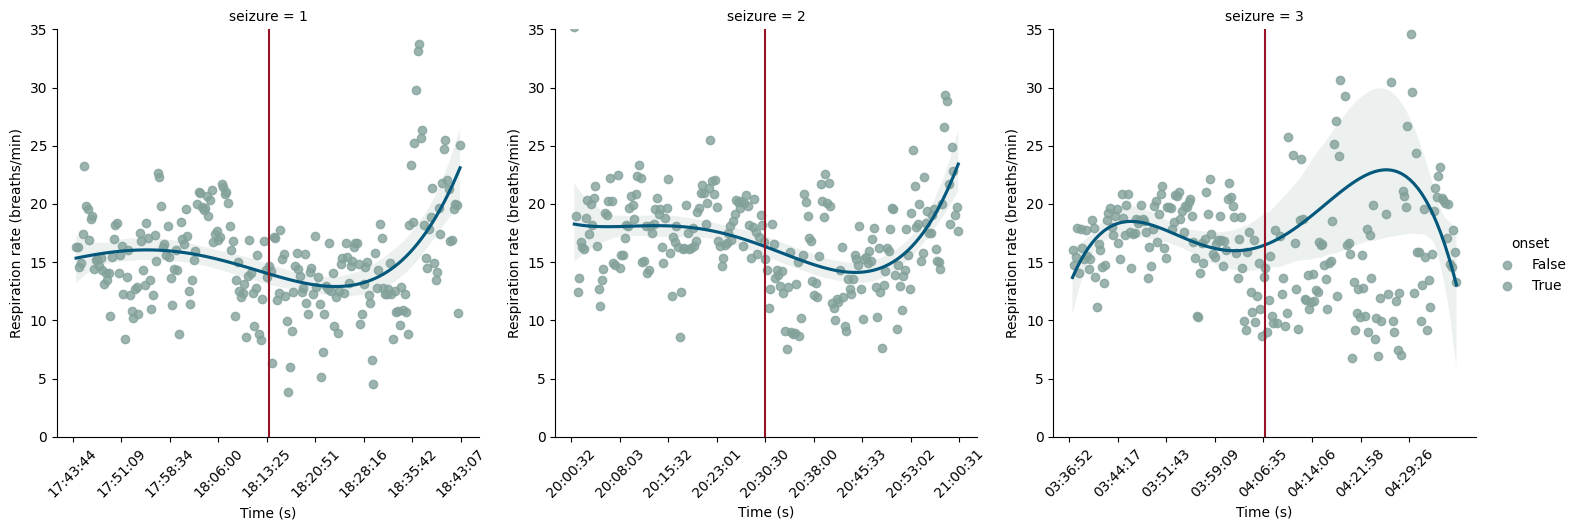

In [143]:


fig = sns.lmplot( data=data_seizures, hue='onset', palette=['#83A19B'], y='resp_rate', x='index', col='seizure', order=4, fit_reg=True, col_wrap=3, sharex=False, sharey=False)
i = 1

for axis in fig.axes:
    seizure_i_data = data_seizures.loc[data_seizures['seizure']==i].copy()
    axis.set_xlabel('Time (s)')
    axis.set_ylabel('Respiration rate (breaths/min)')
    axis.set_ylim(0, 35)#seizure_i_data['resp_rate'].max()+1)
    axis.lines[0].set_color('#03587B')
    axis.set_xticks(seizure_i_data['index'][::len(seizure_i_data)//8])
    axis.set_xticklabels(seizure_i_data['datetime'][::len(seizure_i_data)//8].dt.strftime('%H:%M:%S'), rotation=45)
    axis.vlines(seizure_i_data.loc[seizure_i_data['onset']==True, 'index'], 0, 50, color='#951428')
    i += 1

plt.savefig(f'data/figures{os.sep}{patient}_respiration_rate_seizures.pdf')

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



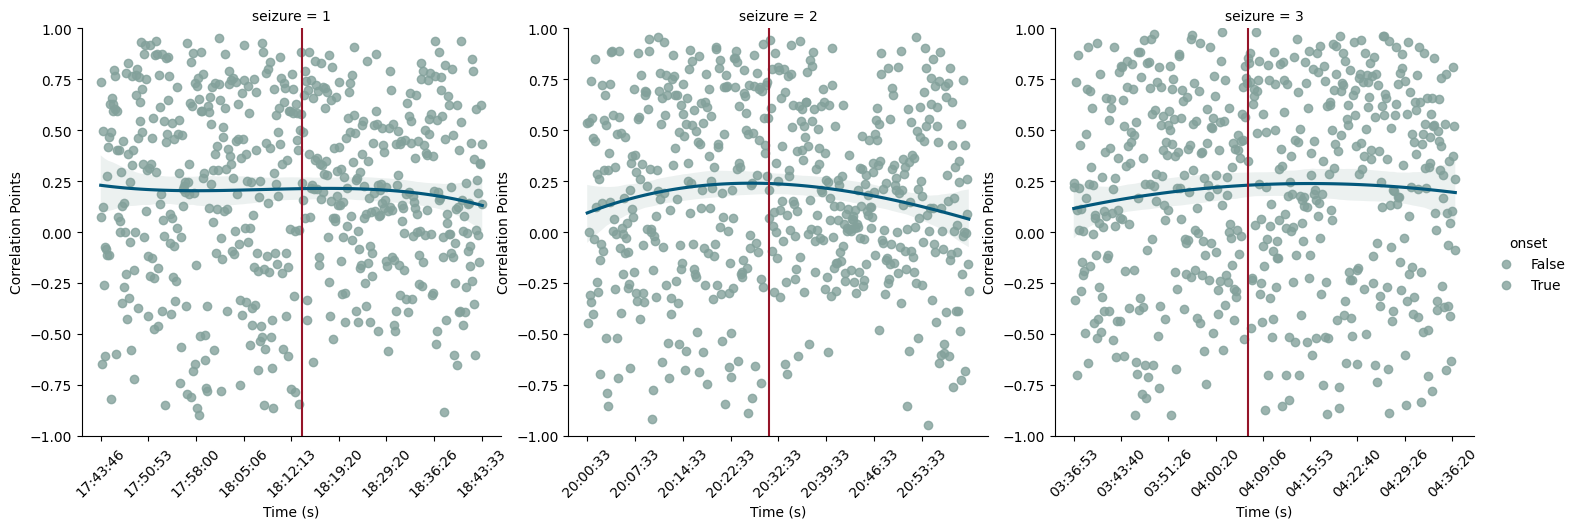

In [154]:




fig = sns.lmplot( data=corr_points_seizures, hue='onset', palette=['#83A19B'], y='corr', x='index', col='seizure', order=3, fit_reg=True, col_wrap=3, sharex=False, sharey=False)
i = 1

for axis in fig.axes:
    seizure_i_data = corr_points_seizures.loc[corr_points_seizures['seizure']==i].copy()
    axis.set_xlabel('Time (s)')
    axis.set_ylabel('Correlation Points')
    axis.set_ylim(-1, 1)#seizure_i_data['resp_rate'].max()+1)
    axis.lines[0].set_color('#03587B')
    axis.set_xticks(seizure_i_data['index'][::len(seizure_i_data)//8])
    axis.set_xticklabels(seizure_i_data['datetime'][::len(seizure_i_data)//8].dt.strftime('%H:%M:%S'), rotation=45)
    axis.vlines(seizure_i_data.loc[seizure_i_data['onset']==True, 'index'], -1, 1, color='#951428')
    i += 1

plt.savefig(f'data/figures{os.sep}{patient}_correlation_seizures.pdf')
# plt.xticks(corr_points_seizure_i['index'][::100], corr_points_seizure_i['relative_time'][::100], rotation=45)

In [ ]:
# plt.figure(figsize=(20, 10))

#sns.lineplot(data=data_seizures, y='resp_rate', x='index', hue='seizure')

fig = px.line(data_seizures.dropna(), x='relative_time', y='resp_rate', color='seizure')
# plt.vlines(x=150000, ymin=0, ymax=40, color='red')
fig.update_layout(xaxis=dict(tickformat="%M:%S"))
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of [] but received: relative_time

## Respiration Analysis in ECG Quality Intervals

In [10]:
# Remove periods of bad quality
# see in segments of 10 seconds
# if the std is too high, remove the whole segment
# if the std is too low, remove the whole segment
timestamps_ = pd.date_range(data_part['datetime'].iloc[0], data_part['datetime'].iloc[-1], freq='10S')

data_part['datetimeS'] = data_part['datetime'].dt.round('10S')

def quality_check(x):
    
    if (x['ECG'].std() < 50) & (x['ECG'].std() > 5):
        print(x['ECG'].std())

        return x
    else:
        return None

data_quality = data_part.resample(on='datetime', rule='10S').apply(lambda x: quality_check(x))


26.548419091718884
5.53420351736353
12.845867893137942
19.977272680792527
45.225345473465026
35.64712996330383
11.66697880210546
34.623537258855926
5.4789315870063
14.008847244328246
22.026698771045027
9.445722340822389
28.70778403686105
24.967533058573068
20.871047979490843
16.35656828108261
35.724768022708666
18.686046719814147
14.617026391173276
14.188597929051074
19.583980074936967
13.908217103556993
13.756336689655782
14.15747799774091
14.07263822590209
13.25165914380465
14.261669638181965
14.131918666037157
14.31137037076466
14.043929765176328
16.49584430793724
14.894862881858115
14.673416053580102
14.331673479916418
14.383372662504302
14.178628442428991
15.69863710619539
16.172039600020316
16.669240165328244
17.965121537351045
14.3191284580876
15.349730511487977
14.880503890005354
14.587918145863501
14.737360642012547
15.175436238503579
13.713095433285066
15.418231728368527
14.986028313650218
21.78503009942793
16.02670446601207
14.924807589477718
14.454461187560407
29.8556703875

<Axes: >

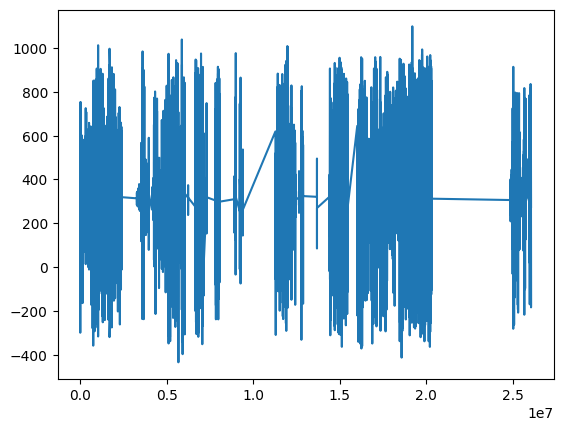

In [11]:
data_quality['ECG'].plot()

In [12]:
data_quality['datetime'] = data_part.loc[data_part.index.isin(data_quality.index)]['datetime']

In [13]:
time_jumps = np.where(data_part['datetime'].diff().dt.total_seconds().values > 0.02)[0]
time_jumps

array([   41368,    53408,    55536,  2265462,  6240574,  6760550,
       11134310, 14294358, 20853622, 21485046])

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [14]:
resp_rate, resp_times = [], []

time_jumps = np.where(data_part['datetime'].diff().dt.total_seconds().values > 0.02)[0]
time_jumps = np.hstack((0, time_jumps, len(data_part)))

for i in range(len(time_jumps)-1):
    resp_rate_, resp_times_ = biosignal_processing.resp_rate(data_part.iloc[time_jumps[i]:time_jumps[i+1]]['RESP'].values, 80)
    print(resp_rate_)
    if 2400 in resp_rate_:
        print('here')
        resp_rate_ = resp_rate_[:resp_rate_.index(2400)]
        resp_times_ = resp_times_[:resp_times_.index(2400)]
    resp_rate.append(resp_rate_)
    resp_times.append(resp_times_ + time_jumps[i])
resp_rate = np.hstack(resp_rate)
resp_times = np.hstack(resp_times)

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[40.639698965192856, 5.751947273816658, 7.121661721068248, nan, nan, nan, nan, 399.99999999999994, 192.0, 104.34782608695654, 141.81818181818184, 73.28244274809161, nan, 16.49484536082474, 12.532637075718014, 8.727272727272727, 28.40236686390533, 9.108159392789373, 17.994376757263353, 21.96796338672769, 80.49689440993791, 61.76470588235294, 44.23963133640552, nan, 13.259668508287291, 7.32824427480916, 11.80327868852459, 9.795918367346939, 11.549566891241582, 17.92382374906647, 8.430913348946135, 11.320754716981133, 20.324629498941423]
[21.70963364993216, 16.644993498049416, 17.125382262996943, 16.374269005847953, 15.946843853820598, 16.658403569657906, 10.805943268797838, 13.816925734024181, 29.447852760736193]
[]
[12.943820224719103, 14.801762114537445, 16.243654822335024, 13.620885357548243, 12.63823064770932, 13.120728929384965, 13.578500707213578, 13.345690454124192, 13.29026303645593, 13.544018058690742, 13.52112676056338, 13.786500718046911, 14.007782101167315, 13.826212193951031

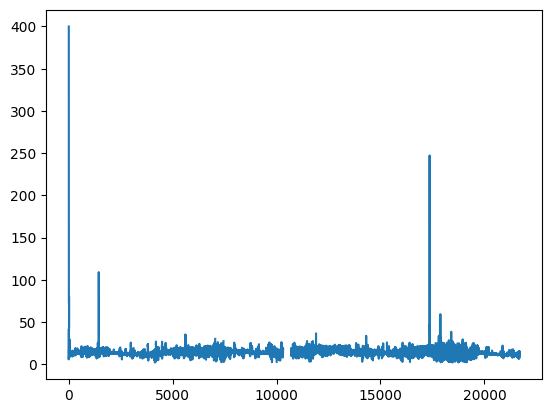

In [15]:
plt.plot(resp_rate)

In [16]:
resp_timestamps = data_part.iloc[resp_times]['datetime']

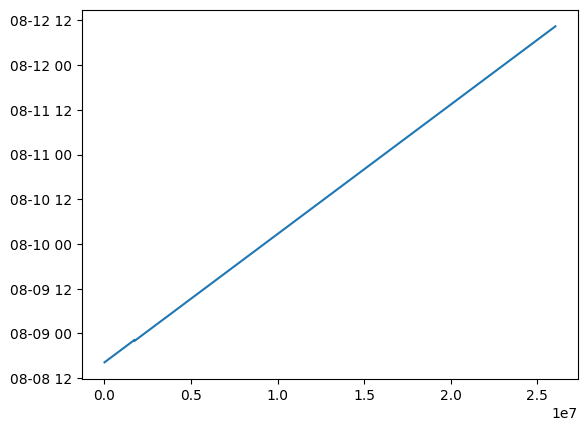

In [17]:
plt.plot(resp_timestamps)

In [18]:
# compare correlation points with respiration rate

resp_df = pd.DataFrame(resp_rate, index=resp_timestamps, columns=['resp_rate'])
resp_df['datetime'] = resp_df.index
resp_df

resp_rate                      datetime
datetime                                                              
2022-08-08 16:13:18.194813198  40.639699 2022-08-08 16:13:18.194813198
2022-08-08 16:13:33.195146797   5.751947 2022-08-08 16:13:33.195146797
2022-08-08 16:13:48.195480396   7.121662 2022-08-08 16:13:48.195480396
2022-08-08 16:14:03.195813996        NaN 2022-08-08 16:14:03.195813996
2022-08-08 16:14:18.196147595        NaN 2022-08-08 16:14:18.196147595
...                                  ...                           ...
2022-08-12 10:23:26.771953508  14.992192 2022-08-12 10:23:26.771953508
2022-08-12 10:23:41.771957759  15.500538 2022-08-12 10:23:41.771957759
2022-08-12 10:23:56.771962010  11.175786 2022-08-12 10:23:56.771962010
2022-08-12 10:24:11.771966261  12.664908 2022-08-12 10:24:11.771966261
2022-08-12 10:24:26.771970513  14.111718 2022-08-12 10:24:26.771970513

[21692 rows x 2 columns]

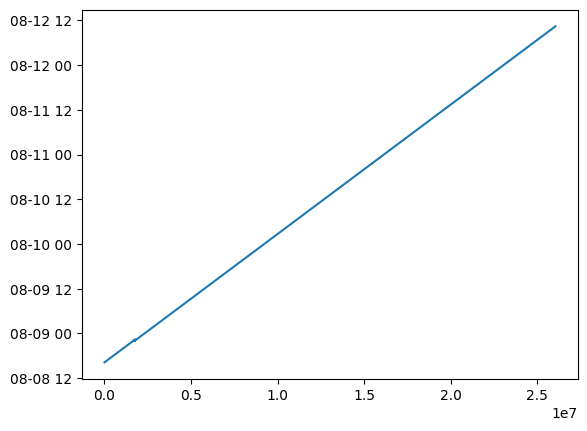

In [19]:
plt.plot(data_quality['datetime'])
plt.show()

In [20]:
data_quality_times = data_quality['datetime'].dt.round('1S').unique()
data_quality_times

<DatetimeArray>
['2022-08-08 16:13:40', '2022-08-08 16:13:41', '2022-08-08 16:13:42',
 '2022-08-08 16:13:43', '2022-08-08 16:13:44', '2022-08-08 16:13:45',
 '2022-08-08 16:13:46', '2022-08-08 16:13:47', '2022-08-08 16:13:48',
 '2022-08-08 16:13:49',
 ...
 '2022-08-12 10:24:11', '2022-08-12 10:24:12', '2022-08-12 10:24:13',
 '2022-08-12 10:24:14', '2022-08-12 10:24:15', '2022-08-12 10:24:16',
 '2022-08-12 10:24:17', '2022-08-12 10:24:18', '2022-08-12 10:24:19',
 '2022-08-12 10:24:20']
Length: 114243, dtype: datetime64[ns]

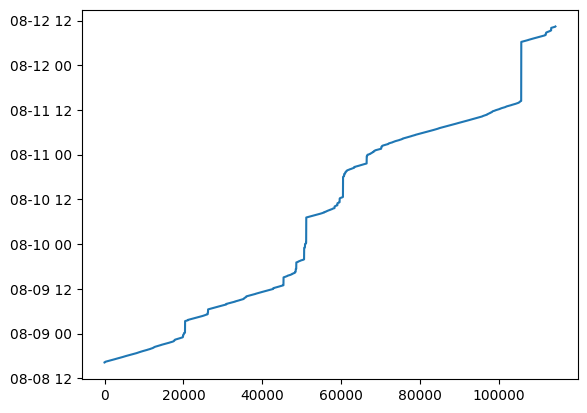

In [21]:
plt.plot(data_quality_times)
plt.show()

In [22]:
corr_points

0                      datetime
2022-08-08 15:53:38.194146000 -0.388250 2022-08-08 15:53:38.194146000
2022-08-08 15:53:44.860812666  0.153587 2022-08-08 15:53:44.860812666
2022-08-08 15:53:51.527479333  0.714589 2022-08-08 15:53:51.527479333
2022-08-08 15:53:58.194146000  0.458053 2022-08-08 15:53:58.194146000
2022-08-08 15:54:04.860812666  0.779333 2022-08-08 15:54:04.860812666
...                                 ...                           ...
2022-08-12 10:24:11.530616008  0.905095 2022-08-12 10:24:11.530616008
2022-08-12 10:24:18.197282675  0.299875 2022-08-12 10:24:18.197282675
2022-08-12 10:24:24.863949341  0.841779 2022-08-12 10:24:24.863949341
2022-08-12 10:24:31.530616008  0.380137 2022-08-12 10:24:31.530616008
2022-08-12 10:24:38.197282675 -0.380144 2022-08-12 10:24:38.197282675

[53910 rows x 2 columns]

In [23]:
corr_points_1s = corr_points.resample('1S').mean()

In [24]:
# only at quality points

resp_rate_1s = resp_df.resample('1S', on='datetime').mean()

In [25]:
data_quality_corr = corr_points_1s.loc[corr_points_1s.index.isin(data_quality_times)].copy()
data_quality_corr['datetime'] = data_quality_corr.index

In [26]:
data_quality_rate = resp_rate_1s.loc[resp_rate_1s.index.isin(data_quality_times)].copy()
data_quality_rate.ffill(inplace=True)
data_quality_rate

resp_rate
datetime                      
2022-08-08 16:13:40        NaN
2022-08-08 16:13:41        NaN
2022-08-08 16:13:42        NaN
2022-08-08 16:13:43        NaN
2022-08-08 16:13:44        NaN
...                        ...
2022-08-12 10:24:16  12.664908
2022-08-12 10:24:17  12.664908
2022-08-12 10:24:18  12.664908
2022-08-12 10:24:19  12.664908
2022-08-12 10:24:20  12.664908

[114243 rows x 1 columns]

In [27]:
data_quality_corr = data_quality_corr.merge(data_quality_rate, on='datetime')

In [28]:
data_quality_corr.dropna(inplace=True)

In [29]:
data_quality_corr

0            datetime   resp_rate
15      0.769008 2022-08-08 16:14:24    7.121662
26      0.883572 2022-08-08 16:14:44    7.121662
34      0.167968 2022-08-08 16:15:11    7.121662
41      0.580051 2022-08-08 16:15:18  192.000000
47      0.882900 2022-08-08 16:15:24  192.000000
...          ...                 ...         ...
114208  0.761077 2022-08-12 10:21:58   12.624934
114215  0.093305 2022-08-12 10:23:04   12.624934
114226  0.712138 2022-08-12 10:24:04   12.624934
114233  0.905095 2022-08-12 10:24:11   12.664908
114240  0.299875 2022-08-12 10:24:18   12.664908

[16742 rows x 3 columns]

In [30]:
fig = px.scatter(data_quality_corr, x=0, y='resp_rate', title=f'{patient} respiration')
fig.show()

In [309]:
#fig = px.line(data_part.iloc[-1500000:-950000], x='datetime', y=['ECG', 'RESP'])
#fig.show()

In [31]:
fig = px.line(data_quality_corr, y='resp_rate',title=f'{patient} respiration')
#for i in range(len(patient_info.seizure_table)):
#    fig.add_vline(patient_info.seizure_table.iloc[i]['Timestamp'], line_width=3, line_dash='dash', line_color='red')
fig.show()

In [32]:
# histogram in bins of respiration rate bpm

# first bin 0-8 BPM
bpm_08 = data_quality_corr.loc[data_quality_corr['resp_rate'] < 10].copy()
# second bin 8-10 BPM
bpm_10 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 10) & (data_quality_corr['resp_rate'] >= 8)].copy()
# third bin 10-12 BPM
bpm_12 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 12) & (data_quality_corr['resp_rate'] >= 8)].copy()
# fourth bin 12-14 BPM
bpm_14 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 14) & (data_quality_corr['resp_rate'] >= 12)].copy()
# fifth bin 14-16 BPM
bpm_16 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 16) & (data_quality_corr['resp_rate'] >= 12)].copy()
# sixth bin 16-18 BPM
bpm_18 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 18) & (data_quality_corr['resp_rate'] >= 16)].copy()
# seventh bin 18-20 BPM
bpm_20 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 20) & (data_quality_corr['resp_rate'] >= 16)].copy()
# eighth bin 20-22 BPM
bpm_22 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 22) & (data_quality_corr['resp_rate'] >= 20)].copy()
# ninth bin 22-24 BPM
bpm_24 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 24) & (data_quality_corr['resp_rate'] >= 20)].copy()
# tenth bin 24-150 BPM
bpm_150 = data_quality_corr.loc[(data_quality_corr['resp_rate'] < 150) & (data_quality_corr['resp_rate'] >= 24)].copy()

In [40]:
dict_bpm = {0:[0, 8, '0-8'], 1:[8, 10, '8-10'], 2:[10, 12, '10-12'], 
         3:[12, 14, '12-14'], 4:[14, 16, '14-16'], 5:[16, 18, '16-18'], 
         6:[18, 20, '18-20'], 7:[20, 22, '20-22'], 8:[22, 24, '22-24'], 
         9:[24, 200, '24-150']}

data_quality_corr['bpm'] = ''
for i in range(10):
    data_quality_corr.loc[(data_quality_corr['resp_rate'] < dict_bpm[i][1]) & (data_quality_corr['resp_rate'] >= dict_bpm[i][0]), 'bpm'] = dict_bpm[i][2]
data_quality_corr
data_quality_corr.rename(columns={0:'IO Correlation'}, inplace=True)
data_quality_corr.sort_values(by='resp_rate', inplace=True)

In [44]:
len(data_quality_corr.loc[data_quality_corr['bpm'] == '24-150'])

56

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev

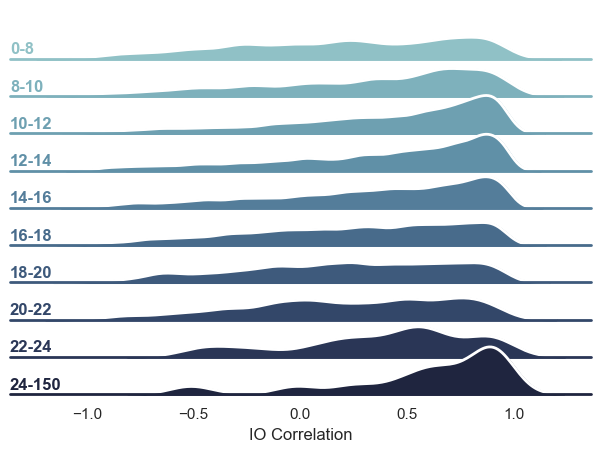

In [42]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data_quality_corr, row="bpm", hue="bpm", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'IO Correlation',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'IO Correlation', clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'IO Correlation')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.savefig(f'data{os.sep}figures{os.sep}{patient}_respiration_correlation.png', dpi=300)


In [45]:
data_quality_corr

IO Correlation            datetime   resp_rate     bpm
35145        -0.003692 2022-08-09 09:14:18    2.233597     0-8
35149         0.644626 2022-08-09 09:14:31    2.233597     0-8
100502        0.233008 2022-08-11 12:25:44    2.582033     0-8
100509        0.762782 2022-08-11 12:25:51    2.582033     0-8
35424         0.223447 2022-08-09 09:30:04    3.658537     0-8
...                ...                 ...         ...     ...
67            0.946781 2022-08-08 16:15:44  104.347826  24-150
75            0.943981 2022-08-08 16:17:31  141.818182  24-150
41            0.580051 2022-08-08 16:15:18  192.000000  24-150
47            0.882900 2022-08-08 16:15:24  192.000000  24-150
54            0.895543 2022-08-08 16:15:31  192.000000  24-150

[16742 rows x 4 columns]

<Axes: xlabel='IO Correlation', ylabel='Density'>

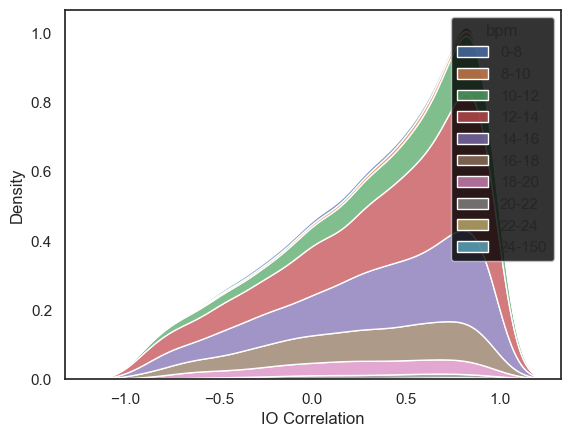

In [46]:

sns.kdeplot(data=data_quality_corr, x='IO Correlation', hue='bpm', multiple='stack')


<Axes: >

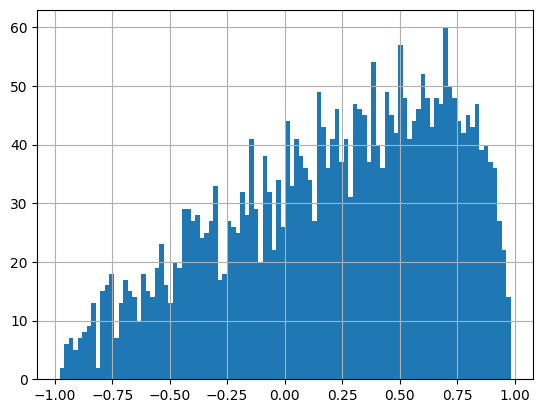

In [29]:
bpm_12[0].hist(bins=100)

<Axes: >

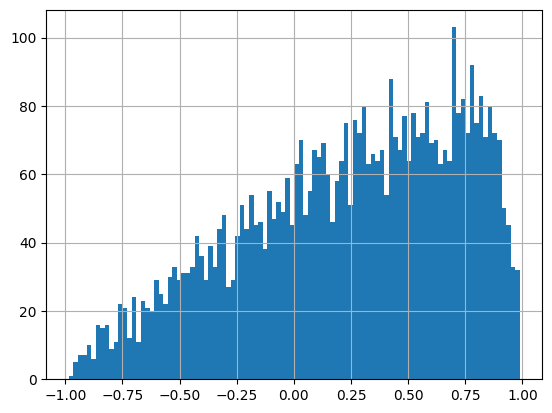

In [30]:
bpm_14[0].hist(bins=100)

<Axes: >

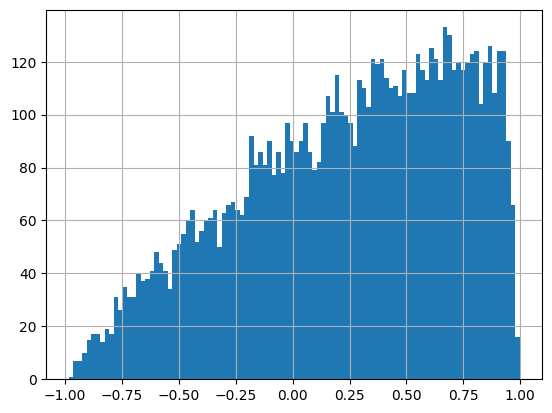

In [32]:
bpm_16[0].hist(bins=100)

<Axes: >

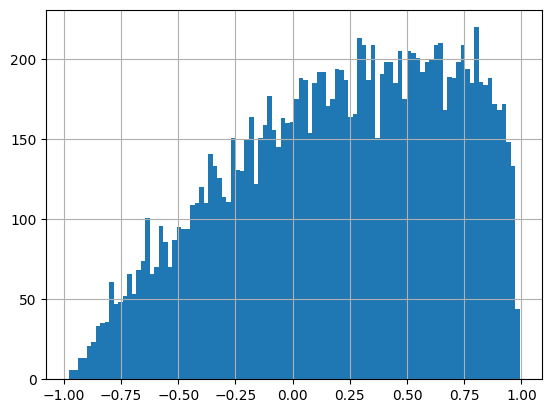

In [33]:
bpm_18[0].hist(bins=100)

<Axes: >

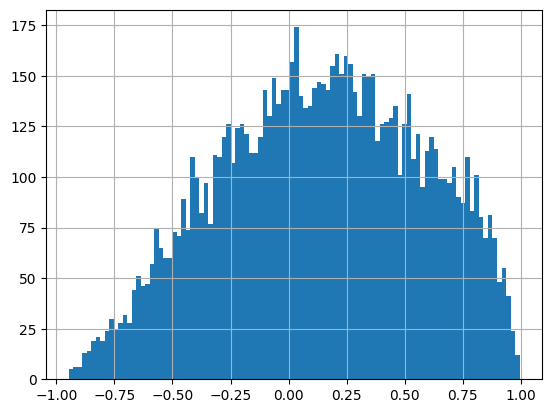

In [34]:
bpm_20[0].hist(bins=100)

<Axes: >

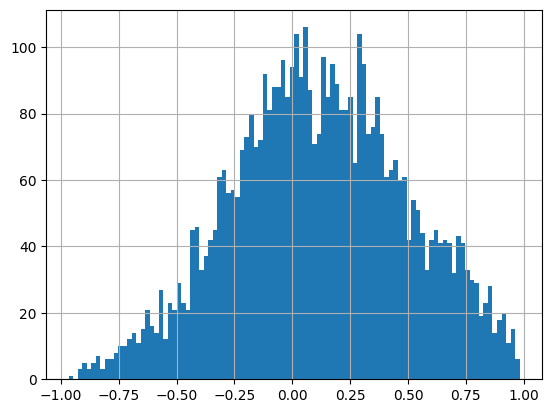

In [35]:
bpm_22[0].hist(bins=100)

<Axes: >

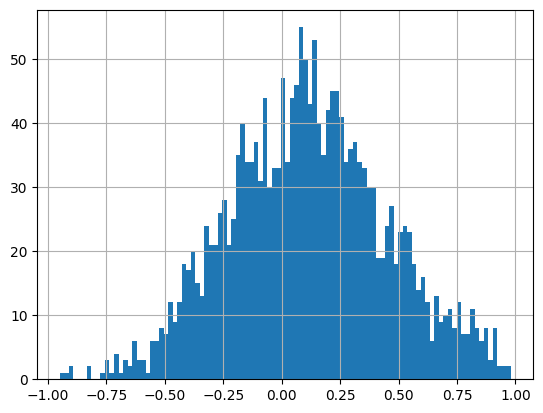

In [36]:
bpm_24[0].hist(bins=100)

<Axes: >

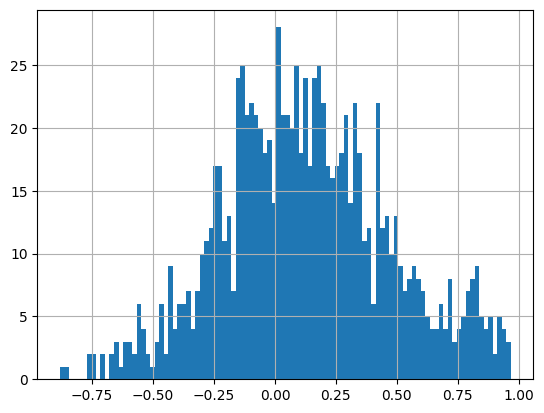

In [37]:
bpm_150[0].hist(bins=100)